In [1]:
import numpy as np
import scipy as sp
import time, datetime
import os
import shutil
import joblib
from skimage.io import imread
import pandas as pd
from skimage import img_as_float
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, make_scorer, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

%matplotlib inline

# 0.1 Set of functions to fit an image with a gaussian

In [2]:
def gaus_moments(data):
    """Returns a dict containing initial guesses for 2D-Gaussian parameters: 
    (background, amplitude, x_mean, y_mean, sigma_x, sigma_y)
    
    Assuming that image is approximately centered"""
    total = data.sum()
    Y, X = np.indices(data.shape)
    x = data.shape[0]/2 #(X*data).sum()/total
    y = data.shape[1]/2 #(Y*data).sum()/total
    col = data[:, int(y)]
    sigma_y = np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()
    row = data[int(x), :]
    sigma_x = np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()
    height = data.min()
    amplitude = data.max() - height
    mom={'background':height, 'amplitude':amplitude, 'x_mean':x, 'y_mean':y, 'sigma_x':sigma_x, 'sigma_y':sigma_y}
    return mom

In [3]:
def twod_gaussian(height, amplitude, center_x, center_y, sig_x, sig_y, sig_xy):
    """Returns a gaussian function with the given parameters"""
    #Sigma = [[sig_x, sig_xy], [sig_xy, sig_y]]
    Sigmin= [[sig_y, -sig_xy], [-sig_xy, sig_x]]/(sig_x*sig_y - sig_xy**2 + 10**-4)
    center = np.array([center_x, center_y]).reshape((1,1,2))
    #print center.shape, Sigmin.shape, center.dot(Sigmin).shape
    return lambda x: height+ amplitude*np.exp(-( (x-center).dot(Sigmin)*(x-center) ).sum(axis=-1)/2)

In [4]:
def fit_gaussian(data):
    """Returns 2D-Gaussian fit parameters:
    (height, amplitude, center_x, center_y, sig_x, sig_y, sig_xy)
    found by a optimizing least squares of an error"""
    mome = gaus_moments(data)
    para = [mome['background'], mome['amplitude'], mome['x_mean'], mome['y_mean'], mome['sigma_x'], mome['sigma_y'], 1.2]
    x = np.stack(np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1])), axis=-1)
    errorfunction = lambda p: np.ravel(twod_gaussian(*p)(x) - data)
    p, success = sp.optimize.leastsq(errorfunction, para)
    #print success
    return p

## 0.2 Set of functions for processing the data

In [5]:
def load_imgs(dir_name='dust_fog', numb = 10):
    """
    Loading 'numb' of images from 'dir_name'
    and reshaping each one into 8 polarization images of shape 30x30
    -------
    Output:   numpy array of shape 'numb' x 8 x 30 x 30
    """
    dir_name = 'D:/NEWSdm/crops/'+dir_name
    img_arr = []
    num_i = 0
    for img_name in os.listdir(dir_name):
        num_i += 1
        if num_i > numb :
            break
        tmp_im = (pd.read_csv(os.path.join(dir_name, img_name), header=None).drop(30, axis=1)).values.reshape((8,30,30))
        img_arr.append(tmp_im)
    return np.array(img_arr)

In [6]:
def imgs_to_params(imgs):
    """
    Takes array (shape=[numb,8,30,30]) of numb x 8 images of shape 30 x 30
    and fits a 2D Gaussian on each of the images.
    -------
    Output: DataFrame with fitting parameters for images in the array.
    """
    params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
    for num in xrange(imgs.shape[0]):
        i=0
        for data in imgs[num]:
            par = np.concatenate(([num+1, i], fit_gaussian(data)))
            par = par.reshape((1,len(par)))
            i += 1
            params = params.append(pd.DataFrame(par,columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy']), ignore_index=True)
    return params

In [7]:
def clean_params(params, up_bound=500):
    """
    Dropping divergent samples (rows) from the dataset.
    Sample is divergent if any parameter (except 'sig_xy') is negative or larger than 'up_bound'
    """
    img_num = params.get('img_num')
    cov_xy = params.get('sig_xy')
    params = params.drop(['img_num','sig_xy'],axis=1)
    params = params[params[params<up_bound]>=0]
    params = pd.concat([img_num, params, cov_xy], axis=1, join='inner')
    return params.dropna()

In [8]:
def params_to_features(params):
    """
    Getting physical features from fitting parameters:
    polarization number, amplitude, center position, rotation (represented by 'sig_xy'), minor axis, eccentrisity, area
    -------
    Output: DataFrame with features for every image
    """
    Sigms = params.get(['sig_x','sig_y','sig_xy']).values
    idx = params.index
    #print Sigms.shape
    a_ar = []
    area_ar = []
    eps_ar = []
    for s in Sigms:
        #print s
        a, b = np.linalg.eigvalsh([[s[0],s[2]],[s[2],s[1]]])
        if a>b:
            tmp = a
            a = b
            b = tmp
        a_ar.append(a)
        area_ar.append(np.pi * a * b)
        eps = b/a
        if eps<1: eps = 1/eps
        eps_ar.append(eps)
    ellip_par = pd.DataFrame(data={'minor_ax':a_ar, 'eps':eps_ar, 'area':area_ar}, index=idx)
    #print ellip_par.shape
    feat = params.drop(['img_num','height','sig_x','sig_y'],axis=1)
    feat = pd.concat([feat, ellip_par], axis=1)
    return feat

In [9]:
def feat_to_input(ft_data, cl_names):
    """
    Stacking data with names from 'cl_names' into one DataFrame labeling 'signal' with 1 and 'noise' with 0.
    """
    inp_data = pd.DataFrame(columns=np.concatenate((['target'], ft_data[cl_names[0]].columns.values)) )
    for name in cl_names:
        idx = ft_data[name].index
        if name[0] == 'C' :
            targ = pd.DataFrame(data={'target':np.ones(len(idx))}, index=idx)
        else: targ = pd.DataFrame(data={'target': np.zeros(len(idx))}, index=idx)
        app_data = pd.concat([targ, ft_data[name]], axis=1)
        inp_data = inp_data.append(app_data, ignore_index=True)
    return inp_data    

In [10]:
def clean_quantile_feat(params, quant):
    """
    Dropping few percent most outlying samples using quantiles. Dropping symmetrically for distributions assumed symmetrical.
    """
    polar = params.get('polar')
    params = params.drop(['polar'],axis=1)
    for key in params.keys():
        params = params[ params[key]<params[key].quantile(quant[key]) ]
        if (key[0] == 'c') or (key[0] == 's'):
            params = params[ params[key]>params[key].quantile(1-quant[key]) ]
    params = pd.concat([polar, params], axis=1, join='inner')
    return params.dropna()

### 0.2.1 Special functions for large data samples

In [11]:
# should be improved

def load_and_fit_batches(class_name='dust_fog', numb = 10000, node=1, n_cpu=1, n_0 = 1000):
    """
    Loading 'numb' of samples in total from 'class_name' and fitting them with Gaussians and writing results files.
    1. Taking 'n_0' samples at a time and rewriting the same variables on each iteration.
    2. Pseudo-parallelised by running 'n_cpu' applications at once by hands with different 'node' numbers.
    -------
    Output:
    Written 'csv' files with fitting parameters in specific folders, returns 'nump' totall number of samples processed.
    The resulting files are like 'D:/NEWSdm/crops/csvs/batches/50000/gamma/cpu3_n1_it1_params.csv'
    
    *Important*: 'numb' must be devidible by 'n_0', otherwise up to 'n_0' extra samples wil be processe.
    """
    #Getting the number of iterations on this node.
    i_m = np.int(float(numb)/(n_0 * n_cpu))
    over = np.ceil((float(numb) - i_m*n_0*n_cpu)/n_0)
    if node <= over:
        i_m +=1 # each node has it's own i_m
        
    
    dir_name = 'D:/NEWSdm/crops/'+class_name
    nump = 0
    img_names = os.listdir(dir_name)
    for i in range(i_m):
        #iterating over samples in the batch
        img_arr = []
        for img_name in img_names[(node+i-1)*n_0 : (node+i)*n_0]:
            tmp_im = (pd.read_csv(os.path.join(dir_name, img_name), header=None).drop(30, axis=1)).values.reshape((8,30,30))
            img_arr.append(tmp_im)
        img_arr = np.array(img_arr)
        #getting parametrs of samples in the batch and writing tham to file.
        params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
        for img_num in np.arange(img_arr.shape[0]):
            polar=1
            for data in img_arr[img_num]:
                par = np.concatenate(([img_num+1, polar], fit_gaussian(data)))
                par = par.reshape((1,len(par)))
                polar += 1
                nump += 1
                params = params.append(pd.DataFrame(par,columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy']), ignore_index=True)
        output_name = str(numb)+'/'+class_name+'/cpu'+str(n_cpu)+'_n'+str(node)+'_it'+str(i+1)+'_params'
        params.to_csv('D:/NEWSdm/crops/csvs/batches/'+output_name+'.csv')
    '''
    Пофиксить что самая последняя итерация выбегает за пределы, если не делится нацело.
    '''
    return nump

In [12]:
def read_params_from_names(numb, name):
    """
    Reading and stacking DataFrames with parameters from the specified directory: 
    D:/NEWSdm/crops/csvs/batches/'numb'/name
    """
    dir_name = 'D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/'+name
    params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
    for img_name in os.listdir(dir_name):
        par = pd.read_csv(os.path.join(dir_name, img_name), index_col=0)
        params = params.append(par, ignore_index=True)
    return params

In [13]:
def load_params_to_feat(numb, cl_names, giant=False):
    """
    Reading parameters from files, cleaning them and transforming into features.
    -------
    Output: Dict with features DataFrame for every class name
    """
    dat_params = {}
    ft_data = {}
    for name in cl_names:
        if giant:
            dat_params[name] = read_params_from_names(numb, name)
        else: dat_params[name] = pd.read_csv('D:/NEWSdm/crops/csvs/'+str(numb)+'_'+name+'_params.csv', index_col=0)
        ft_data[name] = params_to_features( clean_params(dat_params[name]) )
    return ft_data

In [49]:
def feat_to_input_split(ft_data, cl_names, test_size=0.1, shuffle=True):
    """
    Stacking data from specified class names together, getting a target variable and performing a train-test split.
    -------
    Output: X_train, X_test, y_train, y_test
    """
    if shuffle:
        inp_data = feat_to_input(ft_data, cl_names)
        X = inp_data.drop(['target'], axis=1).values
        y = inp_data.get('target').values
        X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, test_size=test_size)
    else:
        y_tr = pd.DataFrame().values
        y_tt = pd.DataFrame().values
        X_tr = pd.DataFrame(columns=ft_data[cl_names[0]].columns).values
        X_tt = pd.DataFrame(columns=ft_data[cl_names[0]].columns).values
        for name in cl_names:
            if name[0]=='C': 
                y = np.ones(ft_data[name].shape[0])
            else: y = np.zeros(ft_data[name].shape[0])
            X = ft_data[name].values
            tmp_X_tr, tmp_X_tt, tmp_y_tr, tmp_y_tt = train_test_split(X, y, test_size=test_size, shuffle=False)
            X_tr = np.vstack((X_tr, tmp_X_tr))
            X_tt = np.vstack((X_tt, tmp_X_tt))
            y_tr = np.append(y_tr, tmp_y_tr)
            y_tt = np.append(y_tt, tmp_y_tt)
            
    return X_tr, X_tt, y_tr, y_tt

### 0.2.2 Functions for all polarisations stacked together

In [15]:
def params_to_stacked_polar(params, n_pol=8):
    """
    
    """
    pol_par = pd.DataFrame()
    for i in range(params.shape[0]/n_pol):
        par_slice = params[(i*8):((i+1)*8)]
        par_slice = pd.DataFrame(par_slice.drop(['img_num','polar'],axis=1).values, index=par_slice.get('polar'), columns=par_slice.drop(['img_num','polar'],axis=1).columns)
        #print par_slice.head(2), '\n'
        flat_slice = pd.DataFrame(index=[i])
        for j in np.arange(1,n_pol+1):
            col_slice = np.append(flat_slice.columns.values, [opa+str(int(j)) for opa in par_slice.loc[j].index.values])
            #print col_slice
            flat_slice = pd.DataFrame(np.append(flat_slice.values, par_slice.loc[j].values).reshape((1,-1)), columns=col_slice, index=[i])
        pol_par = pd.concat([pol_par, flat_slice])
    return pol_par

In [16]:
def clean_stacked_params(params, up_bound=500, n_pol=8):
    """
    Dropping divergent samples (rows) from the dataset.
    Sample is divergent if any parameter (except 'sig_xy') is negative or larger than 'up_bound'
    """
    img_num = params.index
    for par in params.columns:
        if par[:6] != 'sig_xy':
            params = params[ params[par]>=0 ]
        params = params[ params[par]<up_bound ]
    print params.shape
    return params.dropna()

In [17]:
def params_to_feat_stacked(params, n_pol=8):
    """
    
    """
    idx = params.index
    feat = params.copy()
    for i in np.arange(1,n_pol+1):
        Sigms = params.get(['sig_x'+str(i),'sig_y'+str(i),'sig_xy'+str(i)]).values
        a_ar = []
        area_ar = []
        eps_ar = []
        b_ar = []
        for s in Sigms:
            a, b = np.linalg.eigvalsh([[s[0],s[2]],[s[2],s[1]]])
            if a>b:
                tmp = a
                a = b
                b = tmp
            a_ar.append(a)
            area_ar.append(np.pi * a * b)
            b_ar.append(b)
            eps_ar.append(b/a)
        ellip_par = pd.DataFrame(data={'min_ax'+str(i):a_ar, 'maj_ax'+str(i):b_ar, 'eps'+str(i):eps_ar, 'area'+str(i):area_ar}, index=idx)
        feat = feat.drop(['height'+str(i),'sig_x'+str(i),'sig_y'+str(i)],axis=1)
        feat = pd.concat([feat, ellip_par], axis=1)
    return feat

In [18]:
class_names = ['C60keV','C80keV','C100keV','dust_fog','gamma']

## 1. Training on 20k samples of each type

In [19]:
repeated = False

##### 1.1 Fitting the images and saving parameters into files
* _repeated_ is for recreating the output directory if you are running the same number of samples not for the first time
* 20000 images on two nodes ~14hours

```
%%time
numb = 20000
if repeated:
    shutil.rmtree('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/')
os.mkdir('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/')
giant_data_numb = {}
for name in class_names:
    os.mkdir('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/'+name+'/')
    repeated = True
    giant_data_numb[name] = load_and_fit_batches(class_name=name, numb=numb, node=1, n_cpu=2)
```

##### 1.2 Loading files with Gaussian parameters and transforming them to input features

In [20]:
%%time
##### Loading previosly saved parameters
numb = 20000

giant_data_params = {}
for name in class_names:
    giant_data_params[name] = read_params_from_names(numb, name)


##### Droping the samples where fit diverges

cleaned_giant_data = {}
for name in class_names:
    cleaned_giant_data[name] = clean_params(giant_data_params[name])


print 'cleaned data shape'

for (key,value) in cleaned_giant_data.iteritems():
    print key,'  \t', value.shape

##### Transforming fitting parameters into physical features of the image

feat_giant_data = {}
for name in class_names:
    feat_giant_data[name] = params_to_features(cleaned_giant_data[name])
    
##### Merging all data into one DataFrame with appropriate target labels (signal/noise)

input_giant_data = feat_to_input(feat_giant_data, class_names)

print input_giant_data.shape, '\n\n', input_giant_data.head(1)

#### Spliting data into train and test
# * Precision is the scorer

X_giant = input_giant_data.drop(['target'], axis=1).values
y_giant = input_giant_data.get('target').values
X_giant_train, X_giant_test, y_giant_train, y_giant_test = train_test_split(X_giant, y_giant, test_size=0.1, stratify=y_giant)

prec_scorer = make_scorer(precision_score)

cleaned data shape
C80keV   	(103013, 9)
C60keV   	(131833, 9)
C100keV   	(147079, 9)
gamma   	(145447, 9)
dust_fog   	(120861, 9)
(648233, 9) 

   target  polar  amplitude   center_x   center_y    sig_xy       area  \
0     1.0    1.0   5.108879  14.329652  14.817351  0.001597  87.683335   

        eps  minor_ax  
0  1.844835  3.889599  
Wall time: 58.1 s


## 2. Training Random Forest

In [21]:
randcla = RandomForestClassifier(n_jobs=2, oob_score=True)

##### 2.1 Cross-validation on 5 folds for small amount of trees

**2.1.1** Using precision as a quality metrics

In [22]:
%%time
giant_rand_scores = []
giant_rand_var = []
n_est = [10, 20, 50, 100, 200]
for n in n_est:
    randcla.set_params(n_estimators=n)
    sco = cross_val_score(randcla, X_giant_train, y_giant_train, scoring=prec_scorer, cv=5)
    giant_rand_scores.append(sco.mean())
    giant_rand_var.append(sco.var())
    print np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%'

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.984 +/- 0.0 %
0.984 +/- 0.0 %
0.984 +/- 0.0 %
0.984 +/- 0.0 %
0.984 +/- 0.0 %
Wall time: 1h 33min 23s


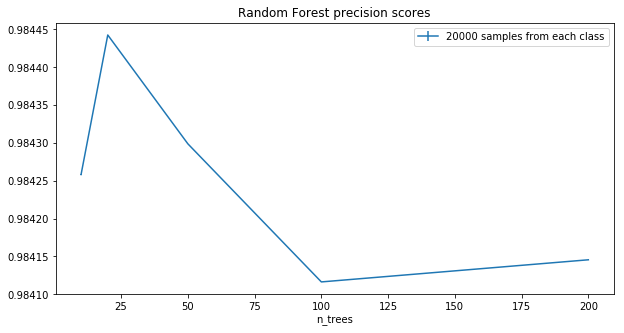

In [23]:
n_est = [10, 20, 50, 100, 200]
plt.figure(figsize=(10,5))
plt.errorbar(n_est, giant_rand_scores, yerr=giant_rand_var, label='20000 samples from each class')
plt.title('Random Forest precision scores')
plt.xlabel('n_trees')
plt.legend()
plt.savefig('RF_cv_20k.pdf')

**2.1.2** Checking accuracy as a quality metrics for 50 trees

In [24]:
%%time
randcla.set_params(n_estimators=50, verbose=0)
sco = cross_val_score(randcla, X_giant_train, y_giant_train, scoring='accuracy', cv=5)
print 'RF accuracy', np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%'

RF accuracy 0.985 +/- 0.0 %
Wall time: 12min 21s


##### 2.2 AUC-ROC and Precision-Recall curves

Detailed check of the algorithms performance for the number of trees that gave best result in previous section (_or 100 trees_)

Algorithm is trained and tested on different classes of signal-background **pair-wise**.

AUC_ROC scores
C60keV__dust_fog   	0.999743
C60keV__gamma   	0.9997354
C80keV__gamma   	0.9997105
C80keV__dust_fog   	0.999702
C100keV__gamma   	0.9998614
C100keV__dust_fog   	0.9999134
Wall time: 10min 2s


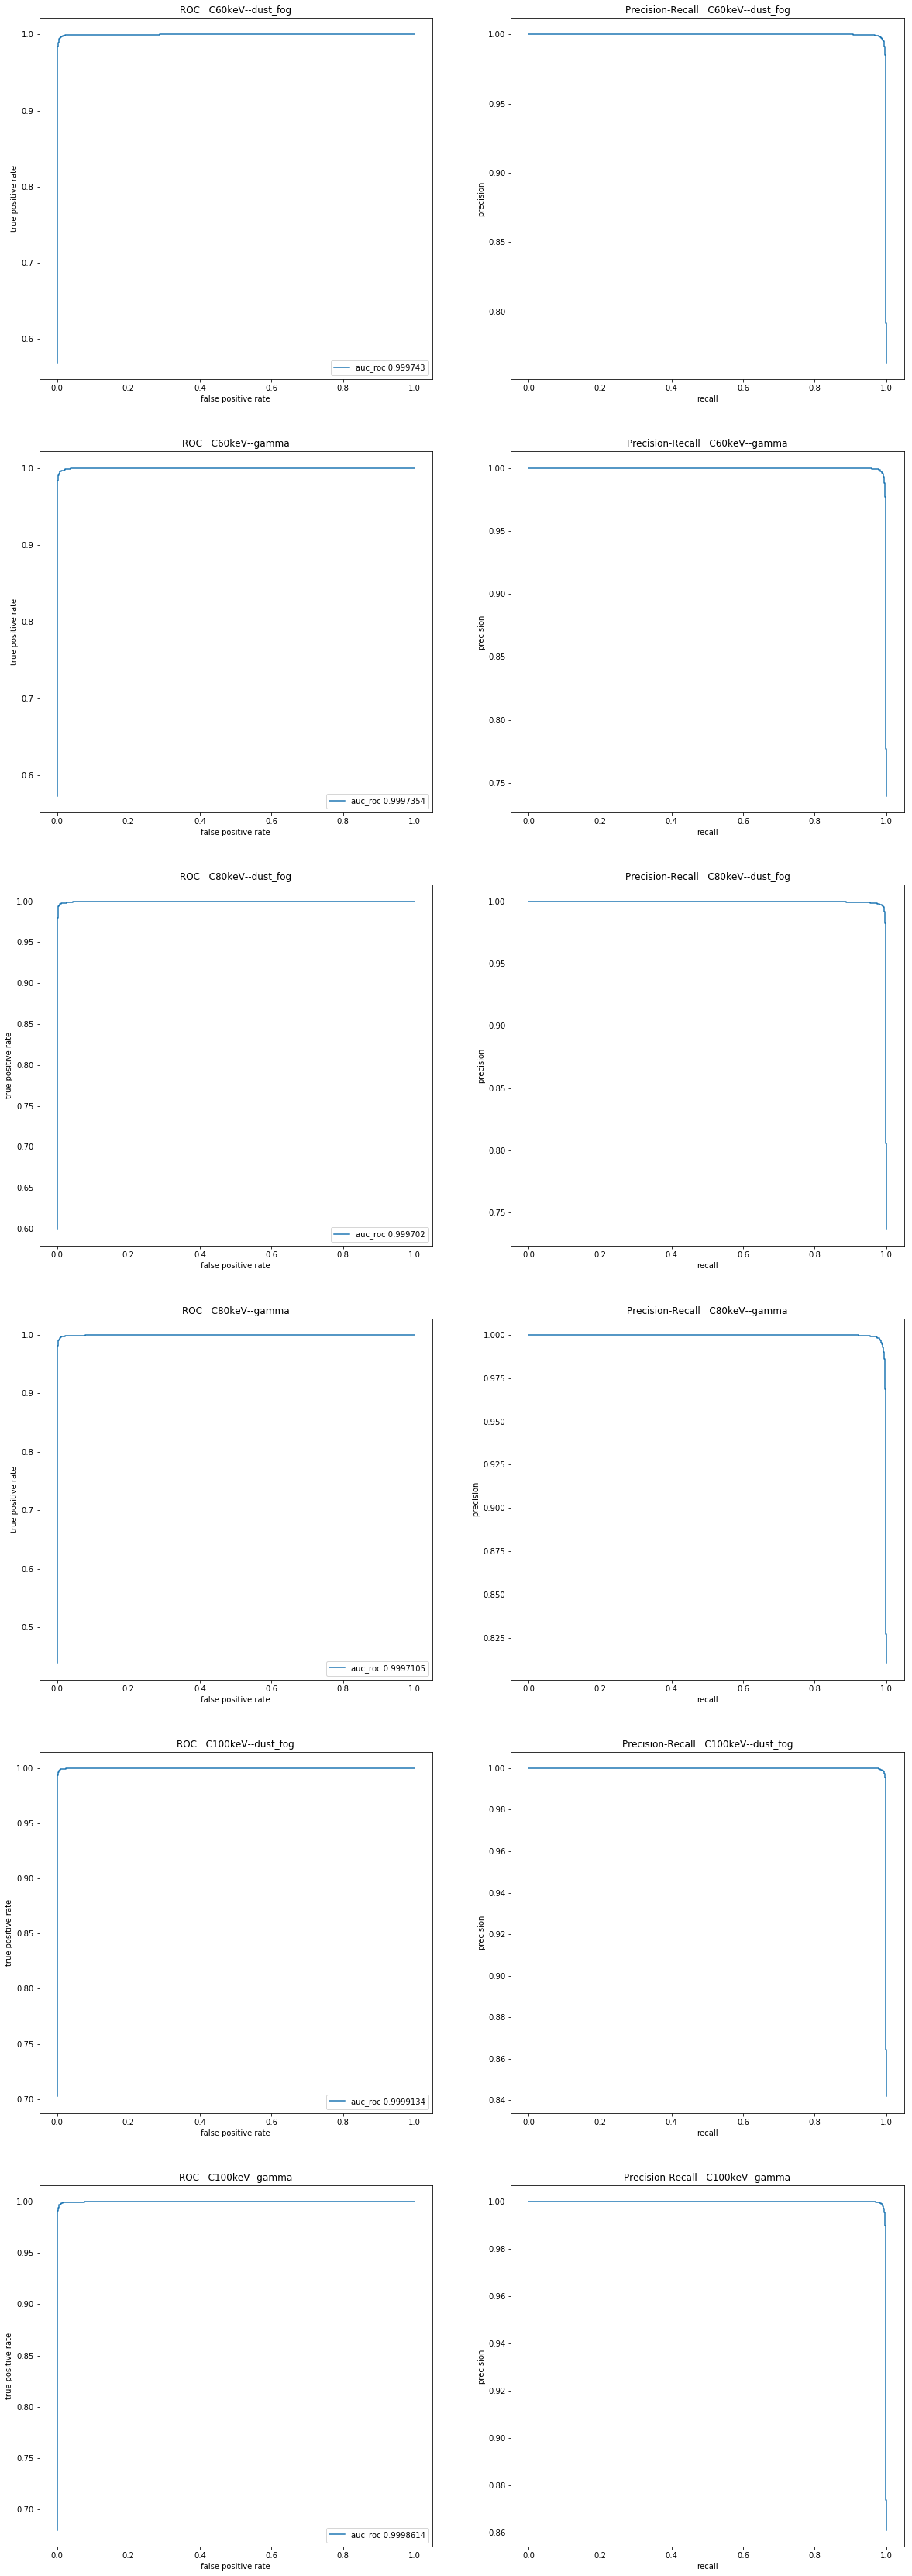

In [25]:
%%time
# Taking the best number of estimators from CV
#randcla.set_params(n_estimators = n_est[np.argmax(giant_rand_scores)])
randcla = RandomForestClassifier(n_estimators=100, n_jobs=2)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            input_data = feat_to_input(feat_giant_data, [name1, name2])
            X = input_data.drop(['target'], axis=1).values
            y = input_data.get('target').values
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            ##### Scoring the RF and building curves
            randcla.fit(X_train_raw, y_train)
            rand_pred = (randcla.predict_proba(X_test_raw))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=7)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print 'AUC_ROC scores'
for (key,value) in auc_rocs.iteritems():
    print key,'  \t', np.around(value, decimals=7)

##### 2.3 Performance for larger number of trees

Checking the behaviour of accuracy/precision/auc-roc/oob-score at the same time.

Training and testing on the whole signal vs whole background.

In [26]:
%%time
big_n_est = [10, 50, 70, 130, 200, 350, 450, 600, 800, 1500, 2200, 3000]
forestzilla_accu = []
forestzilla_prec = []
forestzilla_aucroc = []
forestzilla_oob = []
forestzilla_feat_imp = []
print 'Scores oob(accuracy) vs accuracy vs precision vs auc_roc \t || \t time'
for n in big_n_est:
    tima = datetime.datetime.now()
    randcla.set_params(n_estimators = n, oob_score=True, n_jobs=2)
    X_giant = input_giant_data.drop(['target'], axis=1).values
    y_giant = input_giant_data.get('target').values
    X_giant_train, X_giant_test, y_giant_train, y_giant_test = train_test_split(X_giant, y_giant, test_size=0.1, stratify=y_giant)
    
    randcla.fit(X_giant_train, y_giant_train)
    forestzilla_oob.append(randcla.oob_score_)
    forestzilla_feat_imp.append(randcla.feature_importances_)
    forestzilla_accu.append( accuracy_score(y_giant_test, randcla.predict(X_giant_test)) )
    forestzilla_prec.append( precision_score(y_giant_test, randcla.predict(X_giant_test)) )
    forestzilla_aucroc.append( roc_auc_score(y_giant_test, (randcla.predict_proba(X_giant_test))[:,1]) )
    print '\t', np.around(forestzilla_oob[-1], decimals=4), '  \t', np.around(forestzilla_accu[-1], decimals=4), '  \t', np.around(forestzilla_prec[-1], decimals=4), '  \t', np.around(forestzilla_aucroc[-1], decimals=5), ' \t',str(n)+'_est_time: ', datetime.datetime.now()-tima

Scores oob(accuracy) vs accuracy vs precision vs auc_roc 	 || 	 time
	0.9707   	0.9888   	0.9919   	0.9989  	10_est_time:  0:00:41.544000
	0.991   	0.9921   	0.992   	0.9997  	50_est_time:  0:03:14.825000
	0.9915   	0.9933   	0.9927   	0.99977  	70_est_time:  0:04:32.123000
	0.9923   	0.993   	0.9929   	0.99979  	130_est_time:  0:08:22.980000
	0.9924   	0.9927   	0.9922   	0.99974  	200_est_time:  0:12:46.745000
	0.9925   	0.9931   	0.9924   	0.99978  	350_est_time:  0:22:28.560000
	0.9926   	0.993   	0.9925   	0.99976  	450_est_time:  0:29:02.338000
	0.9927   	0.9929   	0.9926   	0.99976  	600_est_time:  0:38:31.106000
	0.9927   	0.9925   	0.9914   	0.99974  	800_est_time:  0:51:03.773000
	0.9927   	0.9928   	0.9921   	0.99974  	1500_est_time:  1:45:44.281000


KeyboardInterrupt: 

##### 2.3.1 Plotting the behaviour of the quality metrics

In [ ]:
big_n_est = [10, 50, 70, 130, 200, 350, 450, 600, 800, 1500, 2200, 3000]
f, axes = plt.subplots(2, 2, figsize=(20, 11))
f.suptitle('Random Forests performance')
axes = axes.ravel()
axes[0].plot(big_n_est, forestzilla_accu)
axes[0].set_title('Test accuracy')
axes[0].set_xlabel('n_trees')
axes[0].set_xscale('log')
#axes[0].legend()

axes[1].plot(big_n_est, forestzilla_prec)
axes[1].set_title('Test precision')
axes[1].set_xlabel('n_trees')
axes[1].set_xscale('log')
#axes[1].legend()

axes[2].plot(big_n_est, forestzilla_aucroc)
axes[2].set_title('Test auc-roc')
axes[2].set_xlabel('n_trees')
axes[2].set_xscale('log')
#axes[2].legend()

axes[3].plot(big_n_est, forestzilla_oob)
axes[3].set_title('OOB accuracy')
axes[3].set_xlabel('n_trees')
axes[3].set_xscale('log')
#axes[3].legend()
f.savefig('RF_forestzilla_20k.pdf')

#### 2.3.2 Checking the most important parameters

In [ ]:
input_giant_data.drop('target', axis=1).head(0)

In [ ]:
pd.DataFrame(forestzilla_feat_imp, columns=input_giant_data.drop('target', axis=1).columns, index=big_n_est)

### 2.4 Another performance check:
* Training on the merged dataset: (C60+C80+C100)=_signal_, (dust-fog+gamma)=_background_.
* Testing on subsamples of different classes **pair-wise**.

Using 100 trees Forest.

training shape 
(583407L, 8L) (583407L,) 
--------
testing shapes
(25271L, 8L) (25271L,) 
(27729L, 8L) (27729L,) 
(22389L, 8L) (22389L,) 
(24847L, 8L) (24847L,) 
(26795L, 8L) (26795L,) 
(29253L, 8L) (29253L,) 
AUC_ROC scores
C60keV__dust_fog   	0.99973388
C60keV__gamma   	0.99956217
C80keV__gamma   	0.99953958
C80keV__dust_fog   	0.99972822
C100keV__gamma   	0.99978463
C100keV__dust_fog   	0.99987865
Total AUC_ROC score:  0.999708168428
Wall time: 6min 3s


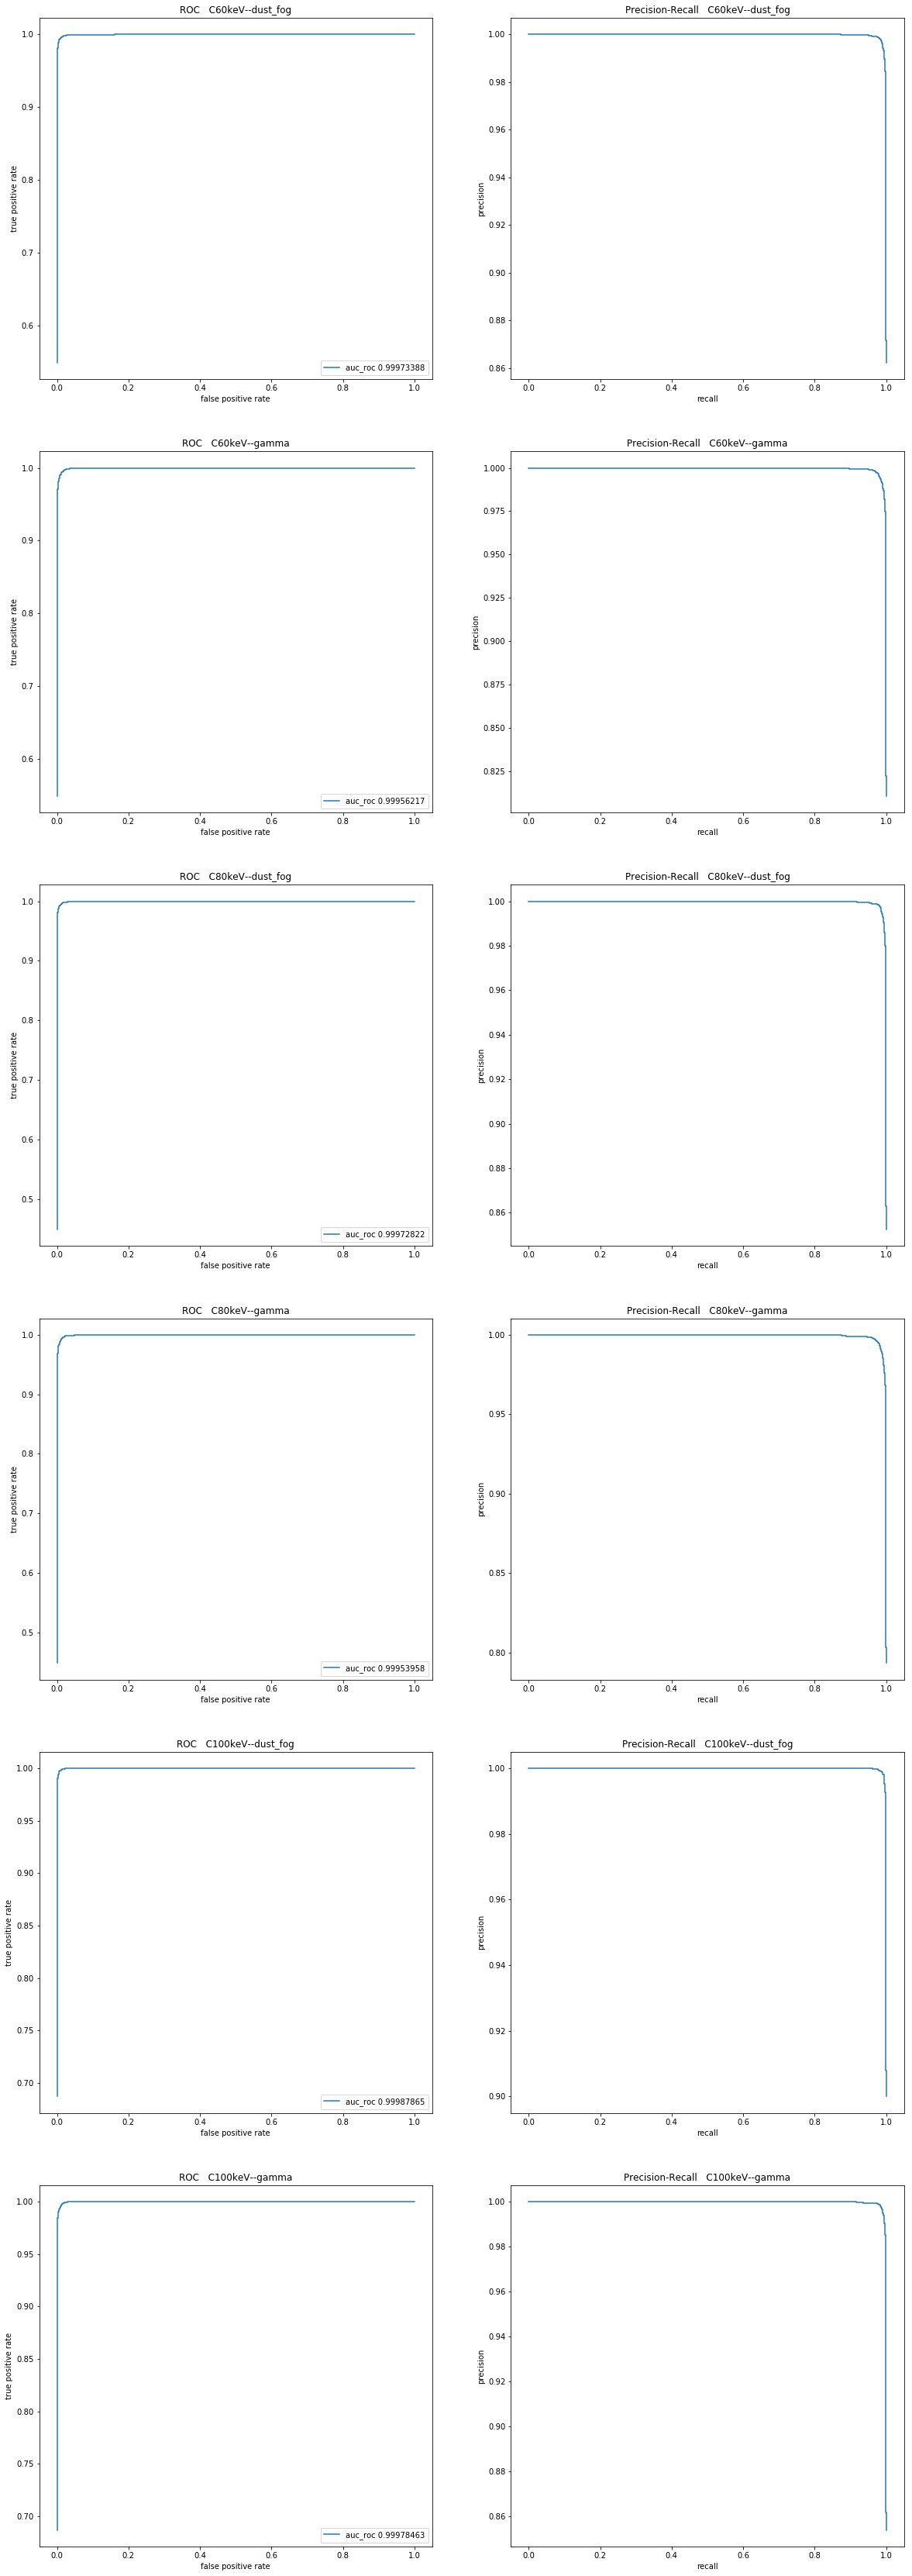

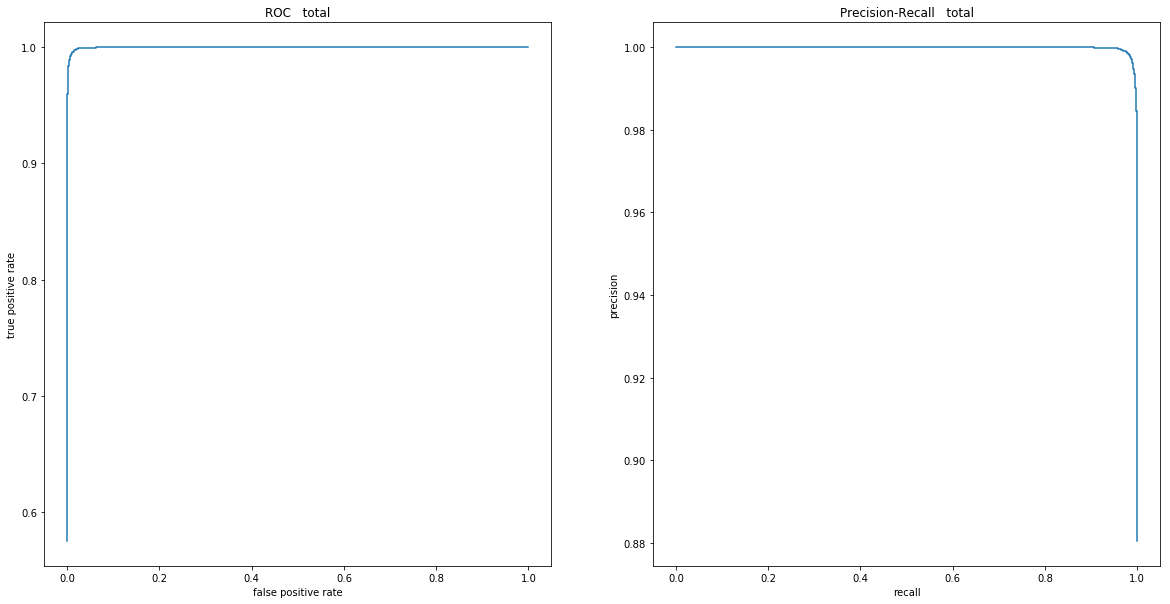

In [27]:
%%time
data_train = {}
data_test = {}
targ_train = {}
targ_test = {}
X_train = pd.DataFrame(columns=feat_giant_data[class_names[0]].columns.values ).values
y_train = []
for name in class_names:
    data_train[name], data_test[name], targ_train[name], targ_test[name] = feat_to_input_split(feat_giant_data, [name], test_size=0.1)
    X_train = np.vstack((X_train, data_train[name]))
    y_train = np.append(y_train, targ_train[name])
    #print '\n-----------\n',feat_giant_data[name].shape,'\n', data_test[name].shape, '\n', targ_test[name].shape, '\n --------------'

#print 'training shape \n',X_train.shape, y_train.shape,'\n--------'
randcla.set_params(n_estimators=100)
randcla.fit(X_train, y_train)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Testing pair-wise
#print 'testing shapes'
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            X_test = np.vstack((data_test[name1], data_test[name2]))
            y_test = np.append(targ_test[name1], targ_test[name2])
            #print '==========\n',X_test.shape, y_test.shape,'\n=========='
            
            rand_pred = (randcla.predict_proba(X_test))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=8)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print 'AUC_ROC scores'
for (key,value) in auc_rocs.iteritems():
    print key,'  \t', np.around(value, decimals=8)
    
X_test = pd.DataFrame(columns=feat_giant_data[class_names[0]].columns.values ).values
y_test = []
for name in class_names:
    X_test = np.vstack((X_test, data_test[name]))
    y_test = np.append(y_test, targ_test[name])
rand_pred = (randcla.predict_proba(X_test))[:,1]
print 'Total AUC_ROC score: ', roc_auc_score(y_test, rand_pred)
fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
f, axes = plt.subplots(1,2, figsize=(20,10))
axes = axes.ravel()
axes[0].step(fpr, tpr)
axes[0].set_title('ROC   total')
axes[0].set_xlabel('false positive rate')
axes[0].set_ylabel('true positive rate')
#axes[0].legend()

prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
axes[1].step(rec, prec)
axes[1].set_title('Precision-Recall   total')
axes[1].set_xlabel('recall')
axes[1].set_ylabel('precision')

###### 2.4.1 Resulting feature importances

In [28]:
pd.DataFrame((randcla.feature_importances_).reshape((1,8)), columns=input_giant_data.drop('target', axis=1).columns, index=[100])

,polar,amplitude,center_x,center_y,sig_xy,area,eps,minor_ax
100,0.047782,0.19147,0.115136,0.119481,0.126868,0.136275,0.1241,0.138887


## 3. Stacking all polarisations together

In [29]:
%%time
giant_stacked_params = {}
for name in class_names:
    giant_stacked_params[name] = params_to_stacked_polar(giant_data_params[name], n_pol=8)

Wall time: 36min 32s


In [30]:
for name in class_names:
    print giant_stacked_params[name].shape

(20000, 56)
(20000, 56)
(20000, 56)
(20000, 56)
(20000, 56)


In [31]:
%%time
cleaned_giant_stacked = {}
for name in class_names:
    cleaned_giant_stacked[name] = clean_stacked_params(giant_stacked_params[name], 500)

(15459, 56)
(8191, 56)
(17701, 56)
(14111, 56)
(16366, 56)
Wall time: 6.03 s


* Too many discarded on C80keV. Probably should loosen the constraint?

In [32]:
%%time
feat_giant_stacked = {}
for name in class_names:
    feat_giant_stacked[name] = params_to_feat_stacked(cleaned_giant_stacked[name])

Wall time: 43.2 s


In [33]:
for name in class_names:
    print feat_giant_stacked[name].shape
feat_giant_stacked['C100keV'].columns

(15459, 64)
(8191, 64)
(17701, 64)
(14111, 64)
(16366, 64)


Index([u'amplitude1', u'center_x1', u'center_y1', u'sig_xy1', u'amplitude2',
       u'center_x2', u'center_y2', u'sig_xy2', u'amplitude3', u'center_x3',
       u'center_y3', u'sig_xy3', u'amplitude4', u'center_x4', u'center_y4',
       u'sig_xy4', u'amplitude5', u'center_x5', u'center_y5', u'sig_xy5',
       u'amplitude6', u'center_x6', u'center_y6', u'sig_xy6', u'amplitude7',
       u'center_x7', u'center_y7', u'sig_xy7', u'amplitude8', u'center_x8',
       u'center_y8', u'sig_xy8', u'area1', u'eps1', u'maj_ax1', u'min_ax1',
       u'area2', u'eps2', u'maj_ax2', u'min_ax2', u'area3', u'eps3',
       u'maj_ax3', u'min_ax3', u'area4', u'eps4', u'maj_ax4', u'min_ax4',
       u'area5', u'eps5', u'maj_ax5', u'min_ax5', u'area6', u'eps6',
       u'maj_ax6', u'min_ax6', u'area7', u'eps7', u'maj_ax7', u'min_ax7',
       u'area8', u'eps8', u'maj_ax8', u'min_ax8'],
      dtype='object')

## 3.1 Training with shuffle in train-test-split

### 3.1.1 Training whole signal vs whole background

In [34]:
%%time
input_giant_stacked = feat_to_input(feat_giant_stacked, class_names)
print input_giant_stacked.shape
X_stacked = input_giant_stacked.drop(['target'], axis=1).values
y_stacked = input_giant_stacked.get('target').values
X_stacked_train, X_stacked_test, y_stacked_train, y_stacked_test = train_test_split(X_stacked, y_stacked, test_size=0.1, stratify=y_stacked)

(71828, 65)
Wall time: 552 ms


In [35]:
%%time
randcla.set_params(n_estimators=100, n_jobs=2)
randcla.fit(X_stacked_train, y_stacked_train)
print 'precision ', precision_score(y_stacked_test, randcla.predict(X_stacked_test))

precision  0.996619990343
Wall time: 59.7 s


### 3.1.2 Comparing signal-background pair-wise

AUC_ROC scores
C60keV__dust_fog   	0.9998606
C60keV__gamma   	0.9999638
C80keV__gamma   	0.9996002
C80keV__dust_fog   	0.9998828
C100keV__gamma   	0.9998902
C100keV__dust_fog   	0.9999762
Wall time: 1min 55s


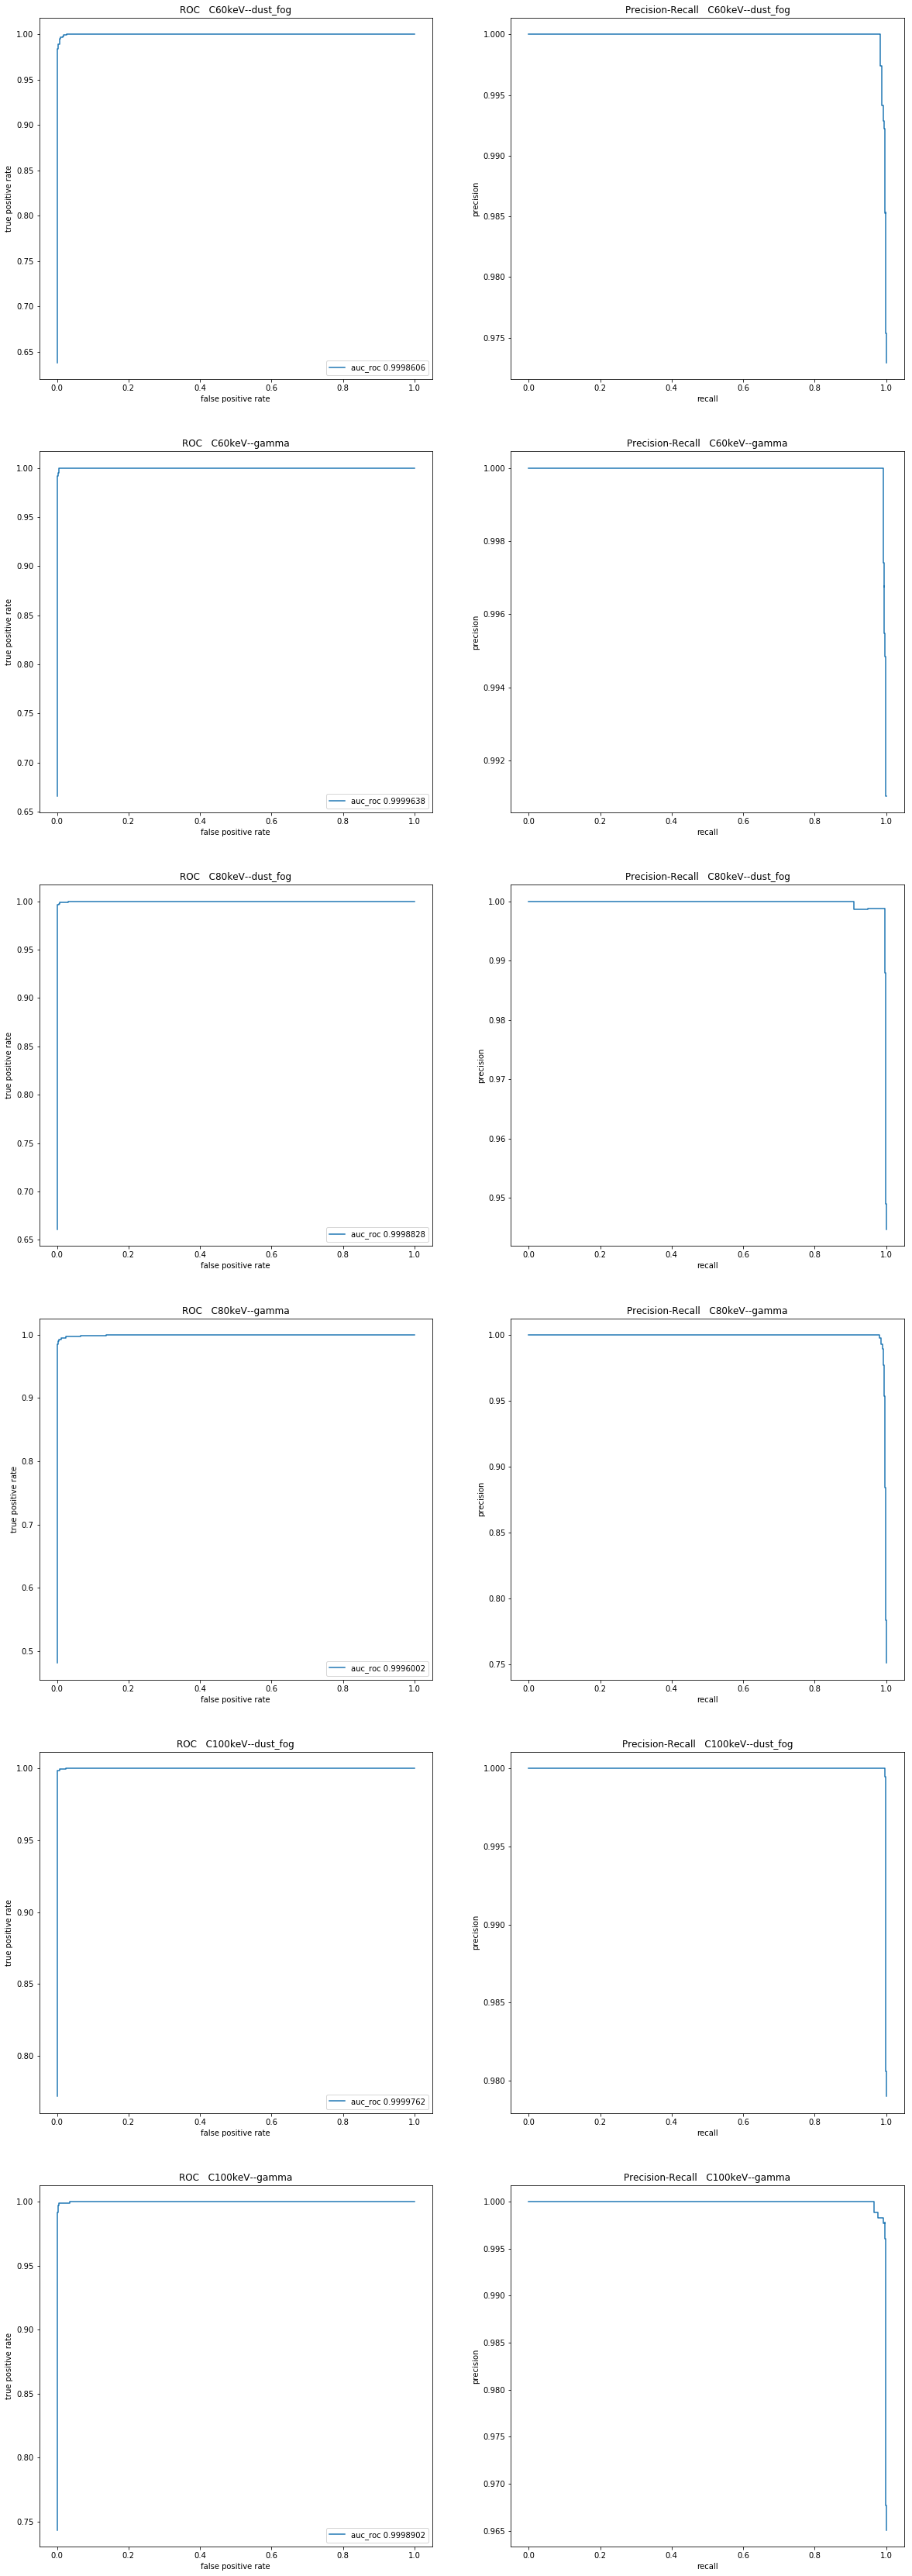

In [36]:
%%time
# Taking the best number of estimators from CV
#randcla.set_params(n_estimators = n_est[np.argmax(giant_rand_scores)])
randcla.set_params(n_estimators=100, n_jobs=2)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            input_data = feat_to_input(feat_giant_stacked, [name1, name2])
            X = input_data.drop(['target'], axis=1).values
            y = input_data.get('target').values
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            ##### Scoring the RF and building curves
            randcla.fit(X_train_raw, y_train)
            rand_pred = (randcla.predict_proba(X_test_raw))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=7)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print 'AUC_ROC scores'
for (key,value) in auc_rocs.iteritems():
    print key,'  \t', np.around(value, decimals=7)

## 3.2 Training without shuffle in train-test-split

### 3.2.1 Training whole signal vs whole background

In [50]:
%%time
X_stacked_unsh_train, X_stacked_unsh_test, y_stacked_unsh_train, y_stacked_unsh_test = feat_to_input_split(feat_giant_stacked, class_names, test_size=0.1, shuffle=False)

Wall time: 873 ms


In [57]:
%%time
randcla.set_params(n_estimators=100, n_jobs=2)
randcla.fit(X_stacked_unsh_train, y_stacked_unsh_train)
print 'precision ', precision_score(y_stacked_unsh_test, randcla.predict(X_stacked_unsh_test))

precision  1.0
Wall time: 54.2 s


In [58]:
randcla.feature_importances_

array([ 0.02276026,  0.00843414,  0.01413693,  0.02028123,  0.02386433,
        0.00823271,  0.00989722,  0.01813226,  0.02530558,  0.00881575,
        0.00860099,  0.01541591,  0.02960119,  0.00803637,  0.00990514,
        0.01465147,  0.02785487,  0.00737615,  0.00984923,  0.0176474 ,
        0.02459726,  0.00836848,  0.00887693,  0.01611394,  0.02345349,
        0.00915445,  0.00875465,  0.01698328,  0.0234179 ,  0.00821543,
        0.00843735,  0.01643183,  0.01583472,  0.01814586,  0.01628757,
        0.01663557,  0.01704744,  0.01439022,  0.01450512,  0.01758542,
        0.0154792 ,  0.01401939,  0.01470747,  0.01435211,  0.01877549,
        0.01547432,  0.01919401,  0.01551481,  0.01885543,  0.01578948,
        0.01677128,  0.01561717,  0.015535  ,  0.01522254,  0.01536292,
        0.01764084,  0.01501288,  0.0151846 ,  0.01452204,  0.01899592,
        0.01547587,  0.01742994,  0.01546664,  0.01756464])

### 3.2.2 Comparing signal-background pair-wise

AUC_ROC scores
C60keV__dust_fog   	1.0
C60keV__gamma   	1.0
C80keV__gamma   	1.0
C80keV__dust_fog   	1.0
C100keV__gamma   	1.0
C100keV__dust_fog   	1.0
Wall time: 2min 4s


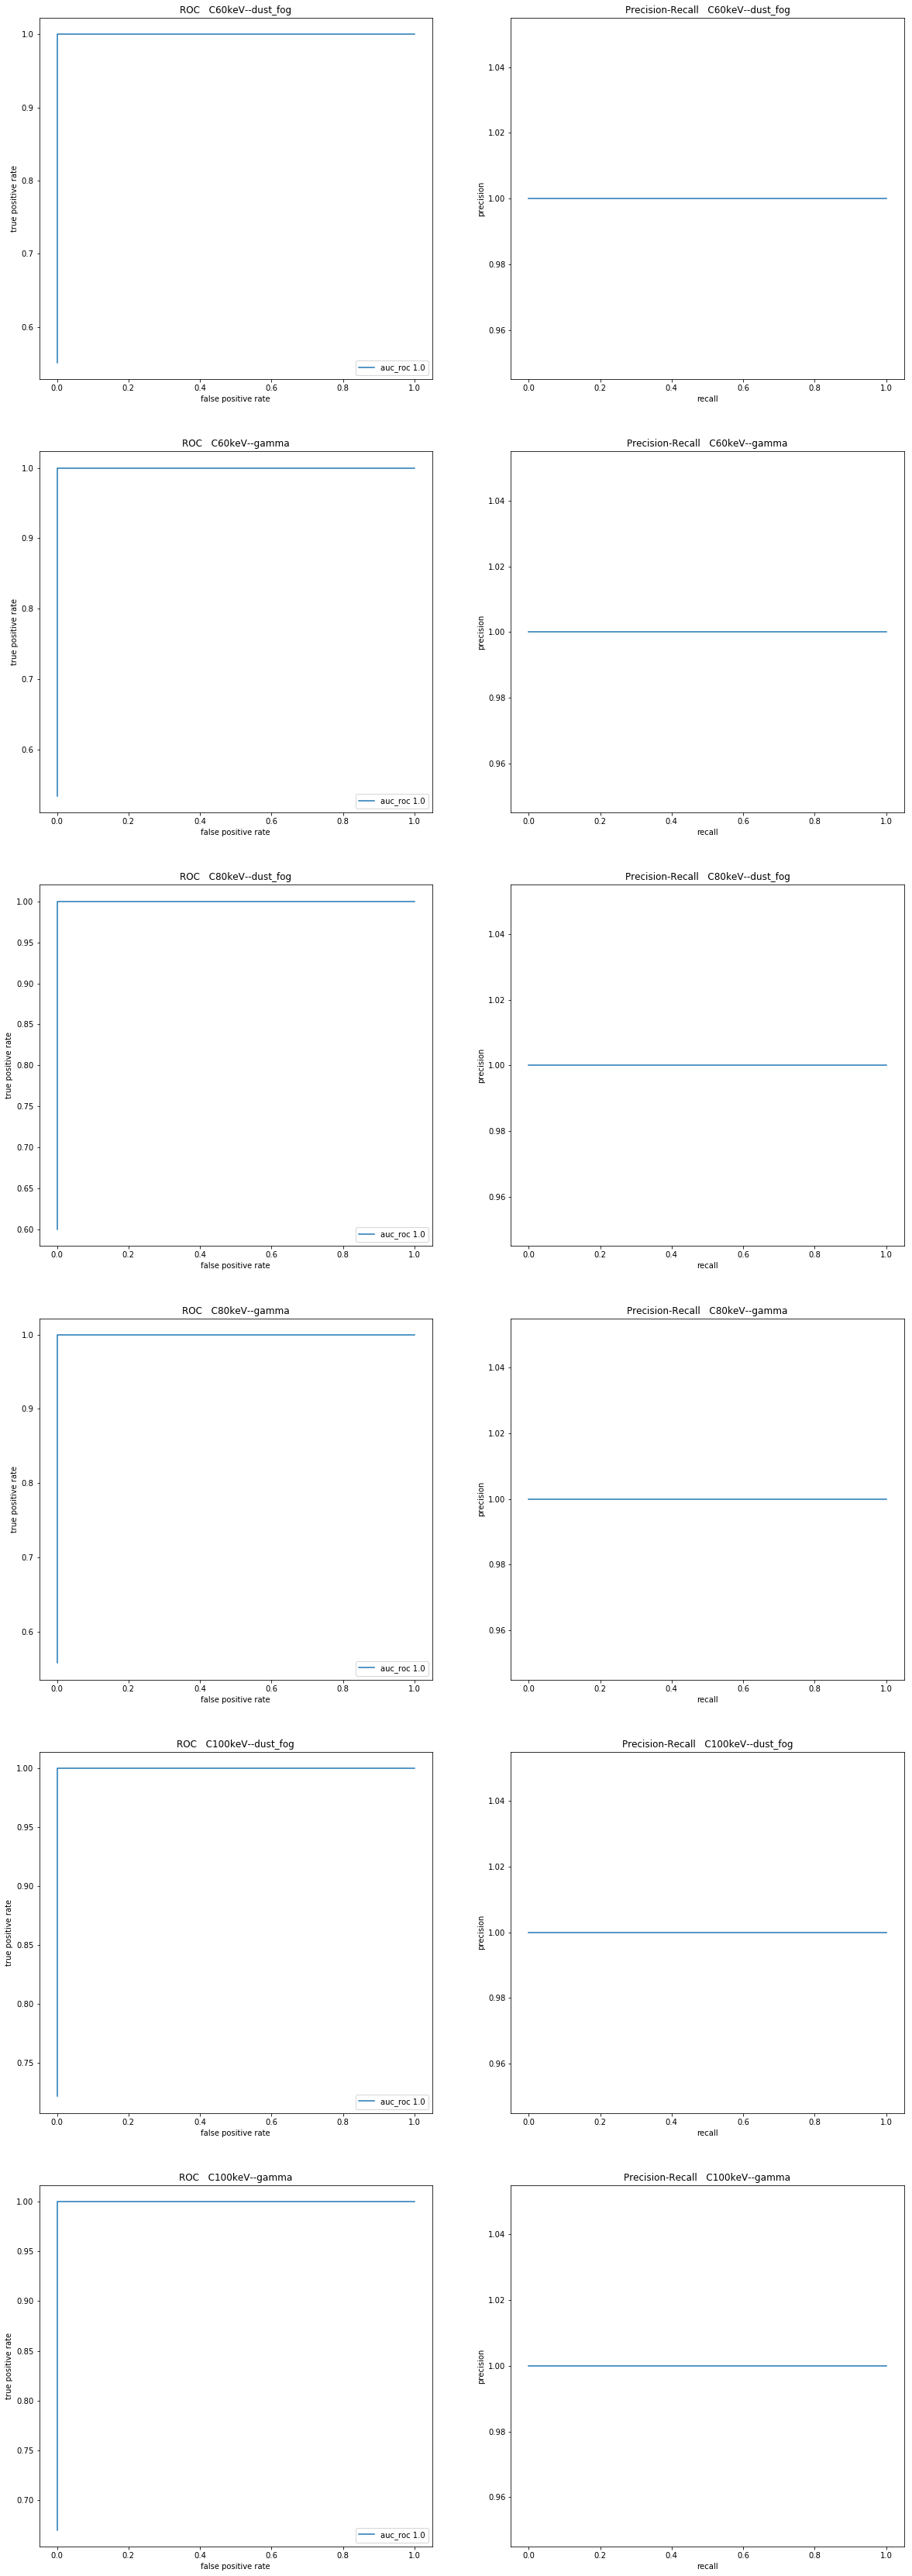

In [56]:
%%time
# Taking the best number of estimators from CV
#randcla.set_params(n_estimators = n_est[np.argmax(giant_rand_scores)])
randcla.set_params(n_estimators=100, n_jobs=2)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            X_train_raw, X_test_raw, y_train, y_test = feat_to_input_split(feat_giant_stacked, [name1, name2], test_size=0.1, shuffle=False)
            ##### Scoring the RF and building curves
            randcla.fit(X_train_raw, y_train)
            rand_pred = (randcla.predict_proba(X_test_raw))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=7)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print 'AUC_ROC scores'
for (key,value) in auc_rocs.iteritems():
    print key,'  \t', np.around(value, decimals=7)

# 51. TESTING AREA

##### <font color='red'> RANDOM CODE HAPPENS </font>

In [38]:
(randcla.feature_importances_).reshape((1,8)).shape

(1L, 8L)

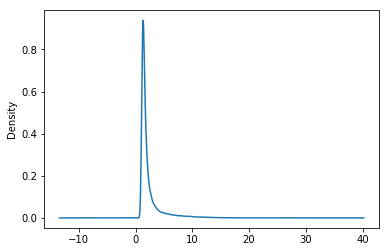

In [75]:
copa = pd.DataFrame(X_train, columns=(feat_giant_data[class_names[0]].columns), copy=True)
quant = {}
for key in feat_giant_data['C100keV'].keys():
    quant[key] = 0.98
quant['minor_ax'] = 0.993
quant['area'] = 0.965
quant['amplitude'] = 0.96
quant['eps'] = 0.999
copa = clean_quantile_feat(copa, quant)
copa['eps'].plot.kde()

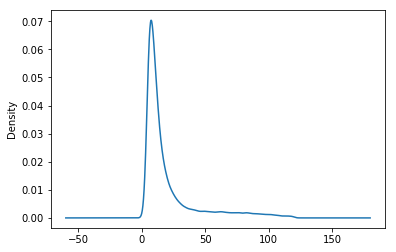

In [76]:
copa['amplitude'].plot.kde()

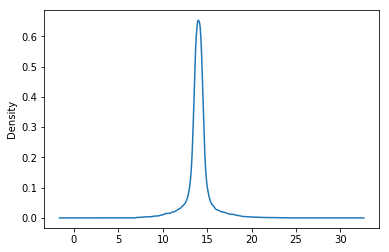

In [77]:
copa['center_x'].plot.kde()

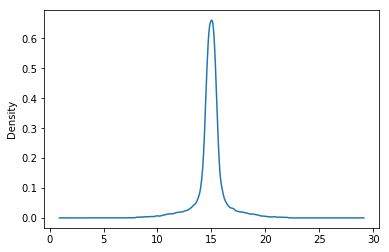

In [78]:
copa['center_y'].plot.kde()

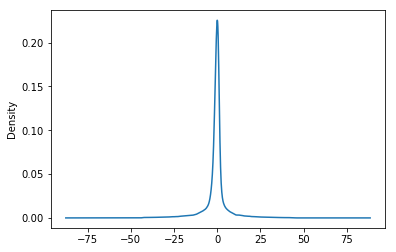

In [79]:
copa['sig_xy'].plot.kde()

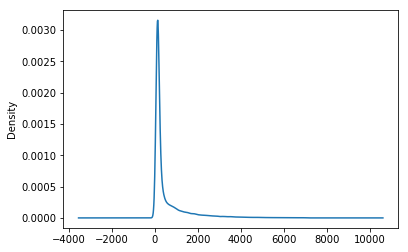

In [80]:
copa['area'].plot.kde()

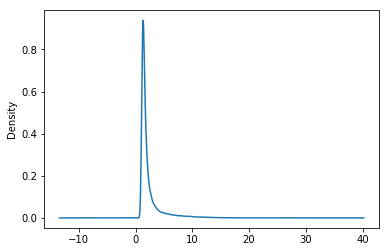

In [81]:
copa['eps'].plot.kde()

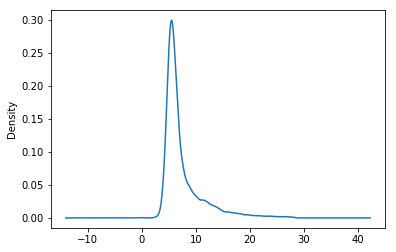

In [82]:
copa['minor_ax'].plot.kde()

In [51]:
copa.head(2)

,polar,amplitude,center_x,center_y,sig_xy,area,eps,minor_ax
0,-1.52904,-0.458042,0.044588,-0.370103,-0.02693,-0.227499,-0.0118322,-0.351877
1,1.08796,-0.289772,-0.0241123,-0.0375481,0.038611,-0.226807,-0.0118322,-0.341122


In [53]:
feat_giant_data['C100keV'].shape

(147079, 8)

In [54]:
copa.shape

(474927, 8)

In [55]:
feat_giant_data[class_names[0]].columns

Index([u'polar', u'amplitude', u'center_x', u'center_y', u'sig_xy', u'area',
       u'eps', u'minor_ax'],
      dtype='object')

In [57]:
copa = pd.DataFrame(giant_data_params['C100keV'][8:16].drop(['img_num','polar'],axis=1).values, index=giant_data_params['C100keV'][0:8].get('polar'), columns=giant_data_params['C100keV'].drop(['img_num','polar'],axis=1).columns)
popa = giant_data_params['C100keV'][8:16].get('img_num').values[0]
print popa
copa

2.0


,height,amplitude,center_x,center_y,sig_x,sig_y,sig_xy
polar,,,,,,,
1.0,25.391546,74.408202,14.409590,14.512226,5.404071,7.672402,0.463731
2.0,24.334133,59.645606,14.329225,14.533185,5.816713,7.875631,0.212840
3.0,23.411457,43.812067,14.374567,14.622436,6.872459,7.786300,0.029967
4.0,22.962829,40.218924,14.459931,14.381284,7.435987,7.190080,0.771465
5.0,23.170918,51.184038,14.415665,14.109579,6.711545,6.680334,1.437820
6.0,23.867563,69.552265,14.395915,14.036434,5.886534,6.656973,1.605094
7.0,24.712152,87.158119,14.413304,14.024474,5.364566,6.851709,1.447891
8.0,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264


In [84]:
jopa = pd.DataFrame(index=[popa])
for i in copa.index:
    nonopa = [iopa+str(int(i)) for iopa in copa.loc[i].index.values]
    print nonopa
    nopa = np.append(jopa.columns.values, [iopa+str(int(i)) for iopa in copa.loc[i].index.values])
    jopa = pd.DataFrame(np.append(jopa.values, copa.loc[i].values).reshape((1,-1)), columns=nopa, index=[popa])
jopa

['height1', 'amplitude1', 'center_x1', 'center_y1', 'sig_x1', 'sig_y1', 'sig_xy1']
['height2', 'amplitude2', 'center_x2', 'center_y2', 'sig_x2', 'sig_y2', 'sig_xy2']
['height3', 'amplitude3', 'center_x3', 'center_y3', 'sig_x3', 'sig_y3', 'sig_xy3']
['height4', 'amplitude4', 'center_x4', 'center_y4', 'sig_x4', 'sig_y4', 'sig_xy4']
['height5', 'amplitude5', 'center_x5', 'center_y5', 'sig_x5', 'sig_y5', 'sig_xy5']
['height6', 'amplitude6', 'center_x6', 'center_y6', 'sig_x6', 'sig_y6', 'sig_xy6']
['height7', 'amplitude7', 'center_x7', 'center_y7', 'sig_x7', 'sig_y7', 'sig_xy7']
['height8', 'amplitude8', 'center_x8', 'center_y8', 'sig_x8', 'sig_y8', 'sig_xy8']


,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
2.0,25.391546,74.408202,14.40959,14.512226,5.404071,7.672402,0.463731,24.334133,59.645606,14.329225,...,5.364566,6.851709,1.447891,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264


In [85]:
copa2 = pd.DataFrame(giant_data_params['C100keV'][16:24].drop(['img_num','polar'],axis=1).values, index=giant_data_params['C100keV'][0:8].get('polar'), columns=giant_data_params['C100keV'].drop(['img_num','polar'],axis=1).columns)
popa2 = giant_data_params['C100keV'][16:24].get('img_num').values[0]
print popa2
copa2

3.0


,height,amplitude,center_x,center_y,sig_x,sig_y,sig_xy
polar,,,,,,,
1.0,29.016990,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935
2.0,28.150002,193.093463,15.341466,29.623590,179.288465,70.205519,69.682300
3.0,26.575359,173.597672,16.182299,31.565013,186.966754,87.170490,78.841862
4.0,25.343270,165.480687,18.744609,35.355382,230.600249,127.183139,113.694306
5.0,24.531754,160.666713,19.298515,36.990574,275.335511,153.809152,136.748951
6.0,25.261131,147.165516,16.298500,33.159565,268.532100,118.681782,110.958290
7.0,26.574131,159.993785,14.602538,30.339340,237.000104,88.380695,84.656662
8.0,28.079039,182.245940,14.161763,29.111200,206.849392,72.375468,69.179624


In [86]:
jopa2 = pd.DataFrame(index=[popa2])
for i in copa2.index:
    nonopa = [iopa+str(int(i)) for iopa in copa2.loc[i].index.values]
    print nonopa
    nopa = np.append(jopa2.columns.values, [iopa+str(int(i)) for iopa in copa2.loc[i].index.values])
    jopa2 = pd.DataFrame(np.append(jopa2.values, copa2.loc[i].values).reshape((1,-1)), columns=nopa, index=[popa2])
jopa2

['height1', 'amplitude1', 'center_x1', 'center_y1', 'sig_x1', 'sig_y1', 'sig_xy1']
['height2', 'amplitude2', 'center_x2', 'center_y2', 'sig_x2', 'sig_y2', 'sig_xy2']
['height3', 'amplitude3', 'center_x3', 'center_y3', 'sig_x3', 'sig_y3', 'sig_xy3']
['height4', 'amplitude4', 'center_x4', 'center_y4', 'sig_x4', 'sig_y4', 'sig_xy4']
['height5', 'amplitude5', 'center_x5', 'center_y5', 'sig_x5', 'sig_y5', 'sig_xy5']
['height6', 'amplitude6', 'center_x6', 'center_y6', 'sig_x6', 'sig_y6', 'sig_xy6']
['height7', 'amplitude7', 'center_x7', 'center_y7', 'sig_x7', 'sig_y7', 'sig_xy7']
['height8', 'amplitude8', 'center_x8', 'center_y8', 'sig_x8', 'sig_y8', 'sig_xy8']


,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
3.0,29.01699,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935,28.150002,193.093463,15.341466,...,237.000104,88.380695,84.656662,28.079039,182.24594,14.161763,29.1112,206.849392,72.375468,69.179624


In [87]:
pd.concat([jopa, jopa2])

,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
2.0,25.391546,74.408202,14.409590,14.512226,5.404071,7.672402,0.463731,24.334133,59.645606,14.329225,...,5.364566,6.851709,1.447891,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264
3.0,29.016990,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935,28.150002,193.093463,15.341466,...,237.000104,88.380695,84.656662,28.079039,182.245940,14.161763,29.111200,206.849392,72.375468,69.179624


In [91]:
range(1,9)

[1, 2, 3, 4, 5, 6, 7, 8]

In [92]:
cocopa = pd.DataFrame()
pd.concat([cocopa, jopa, jopa2])

,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
2.0,25.391546,74.408202,14.409590,14.512226,5.404071,7.672402,0.463731,24.334133,59.645606,14.329225,...,5.364566,6.851709,1.447891,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264
3.0,29.016990,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935,28.150002,193.093463,15.341466,...,237.000104,88.380695,84.656662,28.079039,182.245940,14.161763,29.111200,206.849392,72.375468,69.179624


In [99]:
params_to_polar_params(giant_data_params['C100keV'])

,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
0,2.776381e+01,1.995762e+02,28.563588,29.620876,8.668751e+01,5.388304e+01,2.536415e+01,2.661201e+01,1.995356e+02,30.939559,...,7.372778e+01,5.084722e+01,8.696005e+00,2.822492e+01,1.722285e+02,26.614096,28.616316,7.227201e+01,4.853072e+01,1.151969e+01
1,2.539155e+01,7.440820e+01,14.409590,14.512226,5.404071e+00,7.672402e+00,4.637310e-01,2.433413e+01,5.964561e+01,14.329225,...,5.364566e+00,6.851709e+00,1.447891e+00,2.533295e+01,9.488592e+01,14.385614,14.038993,5.075495e+00,7.051571e+00,1.182264e+00
2,2.901699e+01,2.024732e+02,14.385854,28.860082,1.816252e+02,6.436834e+01,6.325094e+01,2.815000e+01,1.930935e+02,15.341466,...,2.370001e+02,8.838070e+01,8.465666e+01,2.807904e+01,1.822459e+02,14.161763,29.111200,2.068494e+02,7.237547e+01,6.917962e+01
3,5.505314e+00,2.728565e+02,22.818992,28.661497,1.897703e+02,1.786378e+02,7.815249e+01,8.983748e+00,2.753613e+02,24.389845,...,2.508519e+02,3.517310e+02,1.559675e+02,-6.895033e-01,2.911524e+02,24.179668,32.310827,2.153509e+02,2.410866e+02,9.933707e+01
4,2.776381e+01,1.995762e+02,28.563588,29.620876,8.668751e+01,5.388304e+01,2.536415e+01,2.661201e+01,1.995356e+02,30.939559,...,7.372778e+01,5.084722e+01,8.696005e+00,2.822492e+01,1.722285e+02,26.614096,28.616316,7.227201e+01,4.853072e+01,1.151969e+01
5,1.166989e+02,9.629218e+05,-729.961911,1192.339478,3.015027e+04,7.761645e+04,-4.827630e+04,1.230074e+02,3.796358e+05,-644.693647,...,-2.819415e+01,-9.902685e+01,1.513693e+02,2.374841e+02,-1.362114e+02,24.262918,19.872625,9.692272e+01,1.538407e+02,-3.546576e+01
6,-1.601732e+01,2.655621e+02,11.672782,30.903116,1.294814e+03,1.761273e+04,-3.855099e+03,4.062428e+00,2.556285e+02,4.388437,...,2.259476e+03,2.549127e+04,-6.353324e+03,-7.363429e+01,3.195825e+02,14.233401,20.674094,1.634093e+03,1.928599e+04,-4.553862e+03
7,1.214048e+02,9.743294e+05,-704.973799,1134.510785,2.792285e+04,6.975609e+04,-4.404926e+04,1.264898e+02,6.340646e+05,-681.695320,...,1.198701e+02,1.561016e+02,-5.485943e+01,2.377309e+02,-1.368555e+02,23.455443,19.704028,1.005897e+02,1.526842e+02,-3.720866e+01
8,4.216375e+01,2.459860e+02,31.305509,20.439455,2.229782e+02,1.580651e+02,-1.517450e+02,8.091778e+01,2.172332e+01,-10.594196,...,1.427667e+02,1.131543e+02,-9.116374e+01,4.073970e+01,2.453800e+02,29.318656,21.527814,1.608618e+02,1.206412e+02,-1.032348e+02
9,4.216375e+01,2.459860e+02,31.305509,20.439455,2.229782e+02,1.580651e+02,-1.517450e+02,8.091778e+01,2.172332e+01,-10.594196,...,1.427667e+02,1.131543e+02,-9.116374e+01,4.073970e+01,2.453800e+02,29.318656,21.527814,1.608618e+02,1.206412e+02,-1.032348e+02
